In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import sys
import seaborn as sb
import math
from scipy import interpolate
from scipy import linalg
from numpy import random
from scipy.signal import find_peaks
sys.path.append(r'C:\Users\Joar\Documents\1_Education\NTNU\OneDrive - NTNU\Thesis\Modelling\FD Model')

In [2]:
from FloaterParameters import FloaterParameters
from Environment import Environment
from Buoy import Buoy
from Mass import Mass
from Density import Density
from Area import Area
from GlobalCoordinateSystem import GlobalCoordinateSystem
from SystemMatrices import MatrixCalculation
from kSolve import ksolve
from OptimizationProblem import OptimizationProblem
from SpectrumStatistics import spectrum_response_statistics, spectrum_response
from jonswap import jonswap
from RAO_Calculation import calulate_RAOs, calculate_column_raos
from SpectrumStatistics import spectrum_response_statistics, spectrum_response, spectrum_response_statistics_single
from InterpolateHydroDResults import InterpolateResults
from InterpolatePanelPressure import interpolate_panel_pressure
from InternalForceCalculation import InternalForces, rot_calc, calc_centre_of_mass, calc_radius_of_gyration, calc_column_stiffness
from plot_code import sub_plots, sub_plots_spectrums
from WindForceSpectrum import WindForceSpectrum
from ReadWadamLis import ReadWadamLis
from plot_hydroD_results import plot_hydroD_results

In [3]:
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'serif' 

In [4]:
# Pulling simulation results
pull = np.array([60,80,12,14])
# Hand Calculations
mufp = FloaterParameters(pull[0], pull[1], pull[2], pull[3])
env = Environment()
rho = Density()
csa = Area(mufp)
buoy = Buoy(mufp, csa, rho)
mass = Mass(mufp, csa, buoy, rho)
coord = GlobalCoordinateSystem(mufp, csa, mass, rho, buoy, env)
matrix = MatrixCalculation(coord, mass, mufp, rho, env, csa, buoy)
matrix.stiffness[0, 0] = 1e6
matrix.stiffness[1, 1] = 1e6
matrix.stiffness[5, 5] = 1e9

# Diffraction velocity potential - Fixed Simulation

In [5]:
file_name = "\\fixed_motion"
file_loc = r'C:\Users\Joar\Documents\1_Education\NTNU\pickle_files'
file_path = file_loc + file_name
infile = open(file_path, 'rb')
fixed_motion = pickle.load(infile)
infile.close()

In [6]:
rot_force_column = np.zeros(shape=(2,84,3)) + 0j
rot_force_column[:,:,0] = rot_calc(fixed_motion.panel_pressure, fixed_motion, 'roll', [0,0,0])
rot_force_column[:,:,1] = rot_calc(fixed_motion.panel_pressure, fixed_motion, 'pitch', [0,0,0])
rot_force_column[:,:,2] = rot_calc(fixed_motion.panel_pressure, fixed_motion, 'yaw', [0,0,0])

In [7]:
full_body_force = np.zeros(shape=(2,84,3))+ 0j
for ii in np.arange(0, fixed_motion.numheadangles, 1).astype(int):
    for jj in np.arange(0, fixed_motion.numwavelengths, 1).astype(int):
        for kk in [0,1,2]:
            full_body_force[ii, jj, kk] = np.sum(fixed_motion.panel_pressure[ii,jj,:,12+kk])

In [8]:
headangle = 0

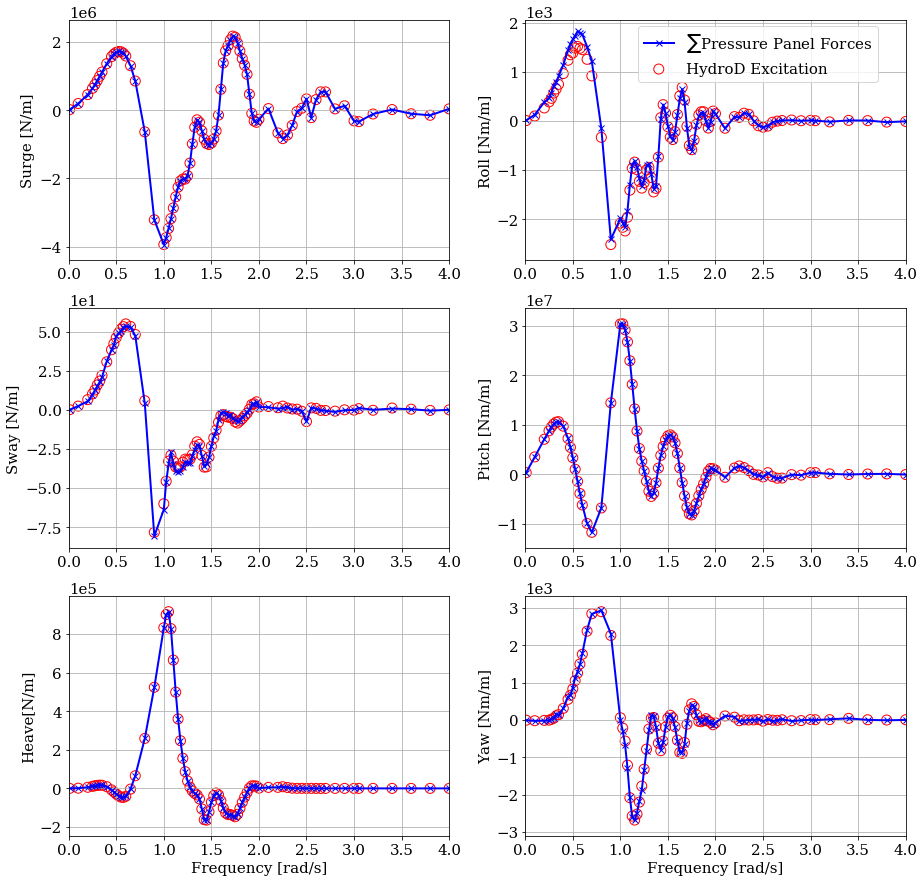

In [9]:
ylab = np.array([['Surge [N/m]', 'Sway [N/m]', 'Heave[N/m]'],
                 ['Roll [Nm/m]', 'Pitch [Nm/m]', 'Yaw [Nm/m]'], ])
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams.update({'font.size': 15})
fig, axs1 = plt.subplots(3, 2)
for jj in [0,1,2]:
        axs1[jj,0].plot(fixed_motion.wave_disc[:,4], np.imag(full_body_force[headangle,:,jj]), '-xb', label='Real - Manual Panel Pressure', linewidth = 2)
        axs1[jj,0].scatter(fixed_motion.wave_disc[:,4], fixed_motion.WAVEEX[headangle,:,jj,1] , label='Real - HydroD Excitation', s=100, facecolors='none', edgecolors='r')
        axs1[jj,0].set(ylabel=ylab[0,jj])
        axs1[jj,0].set(xlim=(0,4))
        axs1[2,0].set(xlabel=('Frequency [rad/s]'))
        axs1[jj,0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
for jj in [3,4,5]:
        axs1[jj-3,1].plot(fixed_motion.wave_disc[:,4], np.imag(rot_force_column[headangle,:,jj-3]), '-xb', linewidth = 2)
        axs1[jj-3,1].scatter(fixed_motion.wave_disc[:,4], fixed_motion.WAVEEX[headangle,:,jj,1] , s=100, facecolors='none', edgecolors='r')
        axs1[2,1].set(xlabel=('Frequency [rad/s]'))
        axs1[jj-3,1].set(ylabel=ylab[1,jj-3])
        axs1[jj-3,1].set(xlim=(0,4))
        axs1[jj-3,1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.figlegend(['$\sum$Pressure Panel Forces', 'HydroD Excitation'], bbox_to_anchor=(.82, .8))

In [10]:
y_lab = ['Surge IF TF [N]','Sway IF TF [N]','Heave IF TF [N]','Roll IF TF [Nm]','Pitch IF TF [Nm]','Yaw IF TF [Nm]']

# Sectional Loads - Free System

In [11]:
plot=0
file_name = "\\free_motion"
file_loc = r'C:\Users\Joar\Documents\1_Education\NTNU\pickle_files'
file_path = file_loc + file_name
infile = open(file_path, 'rb')
hydrod_loads = pickle.load(infile)
infile.close()

In [12]:
hydrod_loads.secloads[:,:,:,0:4,:] *= -1

# Calculating Internal Force Manually

In [13]:
#hydrod_loads.DAMPING += (1/20)*2*np.sqrt(matrix.stiffness * (matrix.mass+hydrod_loads.ADDEDMASS))

In [14]:
RAO_rigid, _, _, _ = calulate_RAOs(hydrod_loads.wave_disc, hydrod_loads.mass_matrix, hydrod_loads.ADDEDMASS, hydrod_loads.DAMPING, hydrod_loads.stiffness_matrix, hydrod_loads.WAVEEX, 0 , mufp, coord)


In [15]:
IF_manual = []
RAO = np.zeros(shape=(3,2,3,84,8)) + 0j

In [16]:
RAO[0,:,:,:,:] = calculate_column_raos(RAO_rigid, matrix, 'front')
RAO[1,:,:,:,:] = calculate_column_raos(RAO_rigid, matrix, 'left')
RAO[2,:,:,:,:] = calculate_column_raos(RAO_rigid, matrix, 'right')

In [17]:
IF_manual.append(InternalForces(hydrod_loads.front_column, hydrod_loads.front_column_force, coord.front_column_df, RAO[0,:,:,:,:], hydrod_loads, hydrod_loads.wave_disc[:,4], csa, rho, env, buoy, mufp, coord, mass))
IF_manual.append(InternalForces(hydrod_loads.left_column, hydrod_loads.left_column_force, coord.left_column_df, RAO[1,:,:,:,:],  hydrod_loads, hydrod_loads.wave_disc[:,4], csa, rho, env, buoy, mufp, coord, mass))
IF_manual.append(InternalForces(hydrod_loads.right_column, hydrod_loads.right_column_force, coord.right_column_df, RAO[2,:,:,:,:],  hydrod_loads, hydrod_loads.wave_disc[:,4], csa, rho, env, buoy, mufp, coord, mass))

In [18]:
sec = 2
# sec = 0 is front
# sec = 1 is left
# sec = 2 is right
headangle = 0

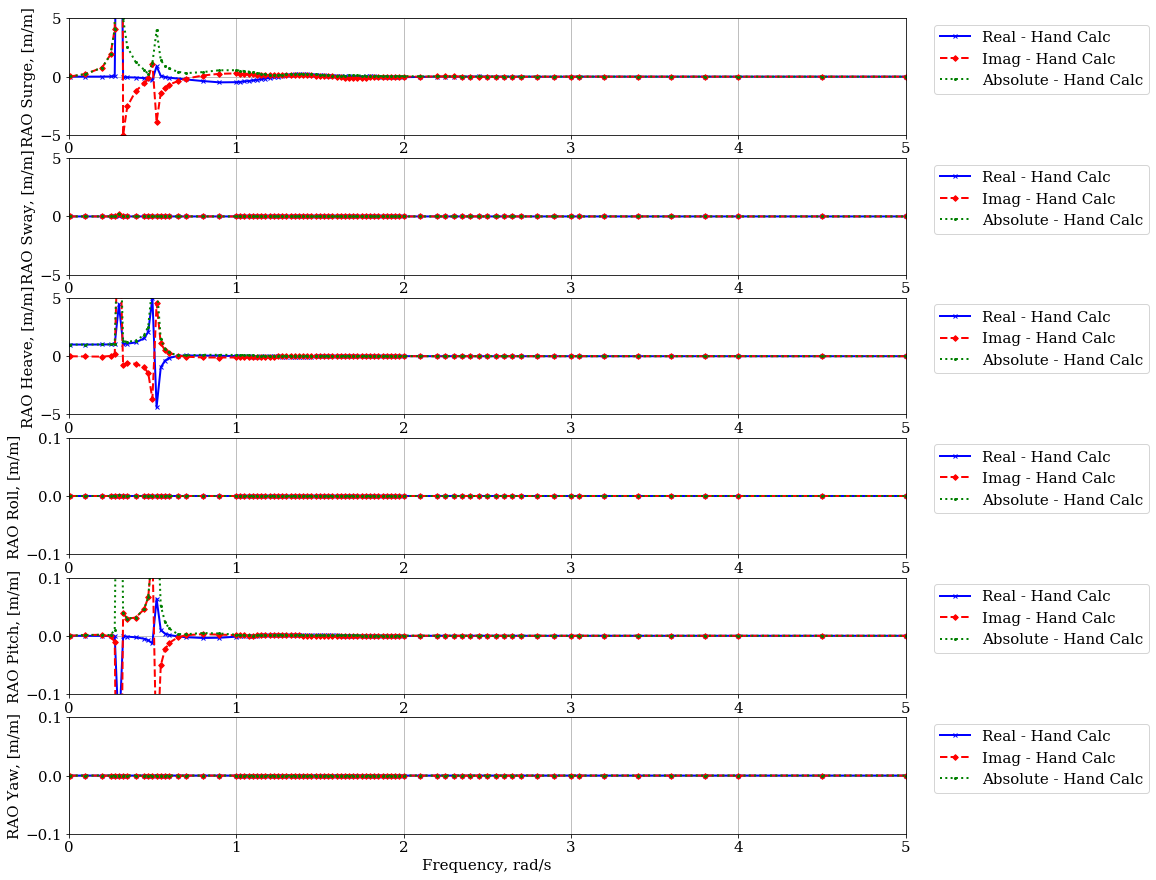

In [19]:
Y_lab = ["RAO Surge, [m/m]",
        "RAO Sway, [m/m]",
        "RAO Heave, [m/m]",
        "RAO Roll, [m/m]",
        "RAO Pitch, [m/m]",
        "RAO Yaw, [m/m]"]
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'serif' 
plot_dof = [0,1,2,3,4,5]
fig, axs = plt.subplots(len(plot_dof))
for x,jj in enumerate(plot_dof):
    axs[x].plot(hydrod_loads.wave_disc[:, 4], np.real(RAO[sec, headangle, 0,:,jj]), '-xb', label="Real - Hand Calc", linewidth=2, markersize=4)
    axs[x].plot(hydrod_loads.wave_disc[:, 4], np.imag(RAO[sec,headangle, 0,:,jj]), '--Dr', label="Imag - Hand Calc", linewidth=2, markersize=4)
    axs[x].plot(hydrod_loads.wave_disc[:, 4], np.absolute(RAO[sec,headangle, 0,:,jj]), ':.g', label="Absolute - Hand Calc", linewidth=2, markersize=4)
    axs[x].set(xlim=[0,5])
    if x < 3:
        axs[x].set(ylim=[-5,5])
    else:
        axs[x].set(ylim=[-0.1,0.1])
    axs[x].set(xlabel ='Frequency, rad/s', ylabel=Y_lab[jj])
    axs[x].legend(loc="upper right", bbox_to_anchor=(1.3, 1.01))
    axs[x].grid(b=True, which='both', axis='both')
plt.rcParams["figure.figsize"] = (15, 5)

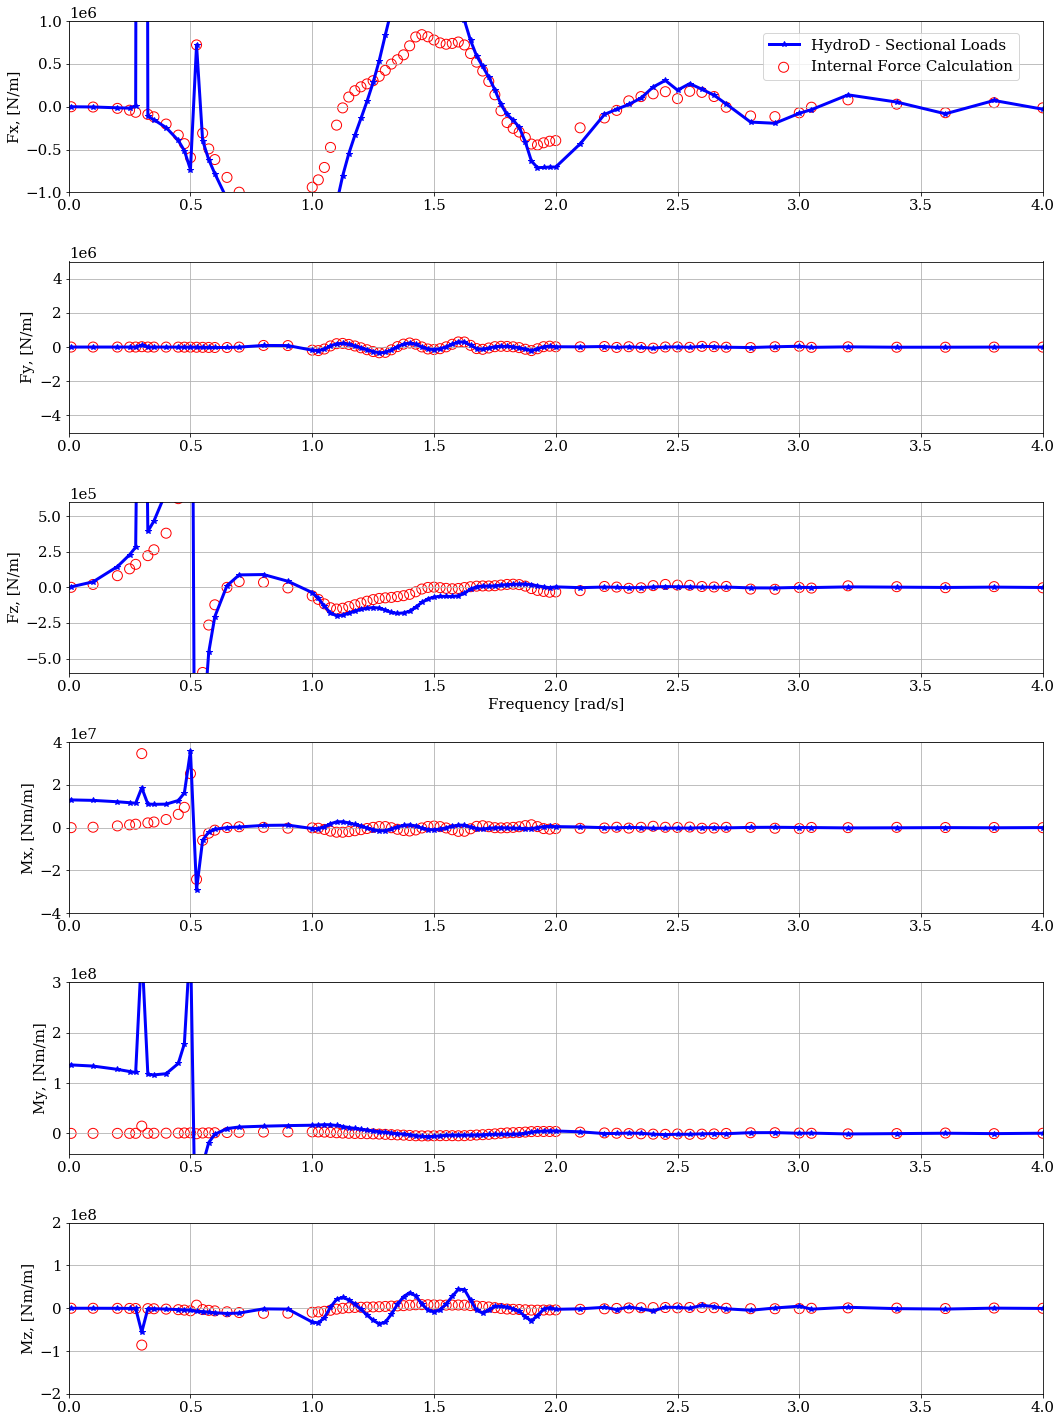

In [20]:
y_lab = ["Fx, [N/m]","Fy, [N/m]","Fz, [N/m]","Mx, [Nm/m]", "My, [Nm/m]","Mz, [Nm/m]"]
plt.rcParams["figure.figsize"] = (15, 20)
plt.rcParams.update({'font.size': 15})
fig, axs1 = plt.subplots(6)
for jj in [0,1,2,3,4,5]:
        axs1[jj].scatter(hydrod_loads.wave_disc[:,4], np.real(hydrod_loads.secloads[headangle,:,sec,jj]), label='HydroD: Internal Force',  s=100, facecolors='none', edgecolors='r')
        axs1[jj].plot(hydrod_loads.wave_disc[:,4], np.real(IF_manual[sec].internal_force[headangle,:,jj]), '-*b', label='Manual Calculation: Internal Force', linewidth=3)
        #if jj < 3:
        #    axs1[jj].plot(hydrod_loads.wave_disc[:,4], np.real(RAO[sec, 2, :, jj]) *IF_manual[sec].mass_column, 'b', label='Acceleration')
        #    axs1[jj].plot(hydrod_loads.wave_disc[:,4], -np.real(IF_manual[sec].force_column[0, :, jj]), 'g', label='Pressure Panels')
        #else:
        #    axs1[jj].plot(hydrod_loads.wave_disc[:,4], np.real(RAO[sec, 2, :, jj]) * IF_manual[sec].mom_of_inert[jj-3], 'b', label='Acceleration')
        #    axs1[jj].plot(hydrod_loads.wave_disc[:,4], -np.real(IF_manual[sec].rot_force_column[0, :, jj-3]), 'g', label='Pressure Panels')
        #axs1[jj].plot(hydrod_loads.wave_disc[:,4], np.real(RAO[sec,0, :, jj])*IF_manual[sec].stiffness_matrix[jj,jj], 'r', label='Stiffness')
        axs1[jj].set(ylabel=y_lab[jj])
        axs1[jj].set(xlim=(0,4))
        axs1[2].set(xlabel=('Frequency [rad/s]'))
        axs1[jj].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
#plt.figlegend(['Manual Calculation','Inertial Load','$\sum$ Pressure Panels','Stiffness', 'HydroD: Internal Force'], bbox_to_anchor=(.82, .77))
plt.figlegend(['HydroD - Sectional Loads', 'Internal Force Calculation'], bbox_to_anchor=(0.95, 0.97))
axs1[0].set(ylim=(-1e6,1e6))
axs1[1].set(ylim=(-5e6,5e6))
axs1[2].set(ylim=(-6e5,6e5))
axs1[3].set(ylim=(-4e7,4e7))
axs1[4].set(ylim=(-4e7,3e8))
axs1[5].set(ylim=(-2e8,2e8))
plt.tight_layout()

In [21]:
RAO.shape

(3, 2, 3, 84, 8)

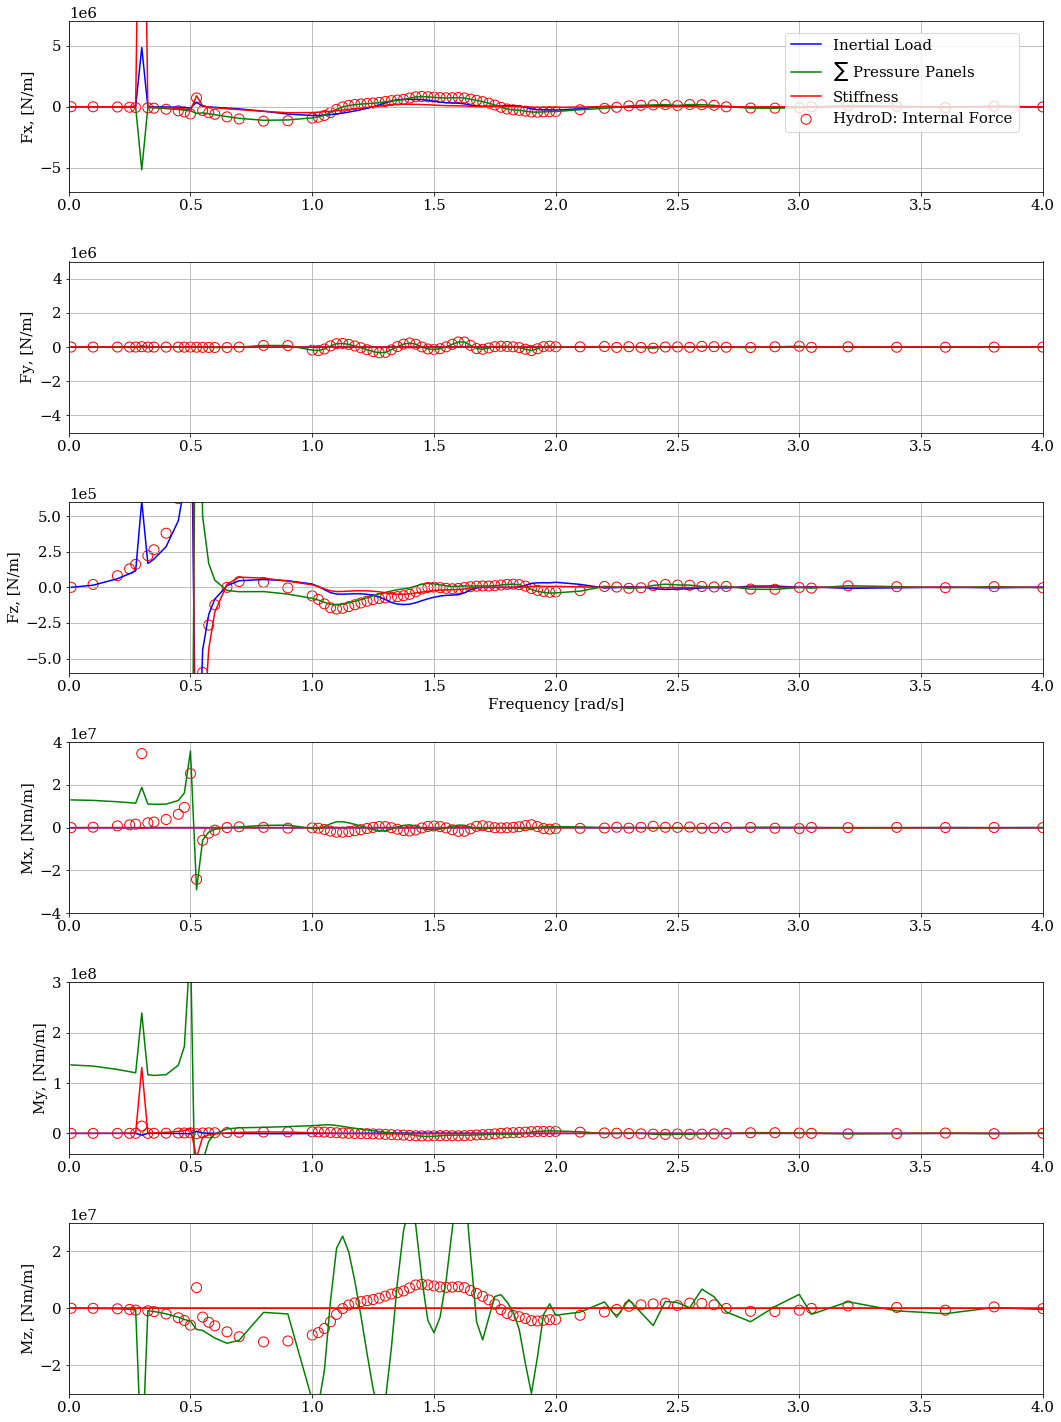

In [23]:
y_lab = ["Fx, [N/m]","Fy, [N/m]","Fz, [N/m]","Mx, [Nm/m]", "My, [Nm/m]","Mz, [Nm/m]"]
plt.rcParams["figure.figsize"] = (15, 20)
plt.rcParams.update({'font.size': 15})
fig, axs1 = plt.subplots(6)
for jj in [0,1,2,3,4,5]:
        axs1[jj].scatter(hydrod_loads.wave_disc[:,4], np.real(hydrod_loads.secloads[headangle,:,sec,jj]), label='HydroD: Internal Force',  s=100, facecolors='none', edgecolors='r')
        #axs1[jj].plot(hydrod_loads.wave_disc[:,4], np.real(IF_manual[sec].internal_force[headangle,:,jj]), '-*b', label='Manual Calculation: Internal Force', linewidth=3)
        if jj < 3:
            axs1[jj].plot(hydrod_loads.wave_disc[:,4], np.real(RAO[sec,headangle, 2, :, jj]) *IF_manual[sec].mass_column, 'b', label='Acceleration')
            axs1[jj].plot(hydrod_loads.wave_disc[:,4], -np.real(IF_manual[sec].force_column[0, :, jj]), 'g', label='Pressure Panels')
        else:
            axs1[jj].plot(hydrod_loads.wave_disc[:,4], np.real(RAO[sec,headangle, 2, :, jj]) * IF_manual[sec].mass_matrix[jj,jj], 'b', label='Acceleration')
            axs1[jj].plot(hydrod_loads.wave_disc[:,4], -np.real(IF_manual[sec].rot_force_column[0, :, jj-3]), 'g', label='Pressure Panels')
        axs1[jj].plot(hydrod_loads.wave_disc[:,4], np.real(RAO[sec,headangle,0, :, jj])*IF_manual[sec].stiffness_matrix[jj,jj], 'r', label='Stiffness')
        axs1[jj].set(ylabel=y_lab[jj])
        axs1[jj].set(xlim=(0,4))
        axs1[2].set(xlabel=('Frequency [rad/s]'))
        axs1[jj].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.figlegend(['Inertial Load','$\sum$ Pressure Panels','Stiffness', 'HydroD: Internal Force'], bbox_to_anchor=(0.95, 0.97))
#plt.figlegend(['Manual Calculation','Inertial Load','$\sum$ Pressure Panels','Stiffness', 'HydroD: Internal Force'], bbox_to_anchor=(.82, .77))
#plt.figlegend(['HydroD - Sectional Loads', 'Internal Force Calculation'], bbox_to_anchor=(0.95, 0.97))
axs1[0].set(ylim=(-7e6,7e6))
axs1[1].set(ylim=(-5e6,5e6))
axs1[2].set(ylim=(-6e5,6e5))
axs1[3].set(ylim=(-4e7,4e7))
axs1[4].set(ylim=(-4e7,3e8))
axs1[5].set(ylim=(-3e7,3e7))
plt.tight_layout()

# Heave

NameError: name 'IF_front' is not defined

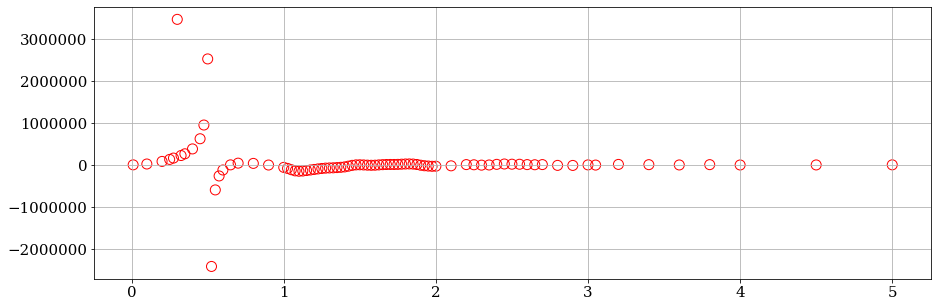

In [24]:
dof = 2
plt.rcParams["figure.figsize"] = (15, 5)
ylim=7e5
y_lab = ["Fx, [N/m]", "Fy, [N/m]", "Fz, [N/m]", "Mx, [Nm/m]", "My, [Nm/m]", "Mz, [Nm/m]"]
plt.scatter(hydrod_loads.wave_disc[:,4], np.real(hydrod_loads.secloads[headangle,:,sec,dof]), label='HydroD: Internal Force',  s=100, facecolors='none', edgecolors='r')
plt.plot(hydrod_loads.wave_disc[:,4], np.real(IF_front.internal_force[0,:,dof]), '-*b', label='Manual Calculation: Internal Force', linewidth=3)
plt.plot(hydrod_loads.wave_disc[:,4], np.real(RAO[2, :, dof]) * IF_front.mass_column, label='Inertial Loads')
plt.plot(hydrod_loads.wave_disc[:,4], -np.abs(IF_front.force_column[0, :, dof]), label='Pressure Panels')
plt.plot(hydrod_loads.wave_disc[:,4], np.real(RAO[0, :, dof])*IF_front.stiffness_matrix[dof,dof], label='Stiffness')
plt.xlabel('Frequency, [rad/s]')
plt.legend(loc="upper right")
plt.xlim(0,5)
if ylim != 0:
    plt.ylim(-ylim,ylim)
plt.ylabel(y_lab[dof])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

# Pitch

In [ ]:
RAO = calculate_column_raos(RAO_rigid[headangle,:,:,:], matrix, 'front')
IF_front = InternalForces(hydrod_loads.front_column, hydrod_loads.front_column_force, coord.front_column_df, RAO, hydrod_loads, hydrod_loads.wave_disc[:,4], csa, rho, env, buoy, mufp, coord)
RAO = calculate_column_raos(RAO_rigid[headangle,:,:,:], matrix, 'left')
IF_left = InternalForces(hydrod_loads.front_column, hydrod_loads.left_column_force, coord.left_column_df, RAO, hydrod_loads, hydrod_loads.wave_disc[:,4], csa, rho, env, buoy, mufp, coord)
RAO = calculate_column_raos(RAO_rigid[headangle,:,:,:], matrix, 'right')
IF_right = InternalForces(hydrod_loads.front_column, hydrod_loads.right_column_force, coord.right_column_df, RAO, hydrod_loads, hydrod_loads.wave_disc[:,4], csa, rho, env, buoy, mufp, coord)